<a href="https://colab.research.google.com/github/RafaGusmao/DataScience-Churn-Prediction/blob/main/Churn_Prediction_for_a_Telecommunications_company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, or simply *churn*, represents the churn rate of your customer base. In services like Spotify or Netflix, it would represent the subscription cancellation rate.

It is extremely important for management and its analysis over time may show that there is a problem that must be addressed.

*Churn* can also be used to identify potential cancellations, in advance, and promote targeted actions to try to retain such customers. This metric should receive attention due to the fact that the Customer Acquisition Cost (CAC) is normally higher than the cost of maintaining them. In other words, a high value for the *churn rate* is what we do not want.

## Data Acquisition

The data used in this project was originally made available on the [IBM Developer teaching platform, and deal with a typical problem for a telecommunications company.
Although there is no explicit information available, the column names provide an understanding of the problem.

In [ ]:
# install Pandas Profiling
!pip install imbalanced-learn -q

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# import the packs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# import data
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# see the first 5 entries
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Visualizing the first 5 entries already allows you to understand how the dataset is composed. Even though there is no definition of the meaning of the feature names, it is possible to infer, since the nature of telecommunications companies are similar.

As seen below, the dataset is composed of 7043 entries and 21 variables.


In [ ]:
print("Lines:\t\t{}".format(df.shape[0]))
print("Columns:\t{}".format(df.shape[1]))

Lines:		7043
Columns:	21


## Exploratory Data Analysis

In order to begin this project, I will check the integrity and usability of the dataset.

To do this, I will print the amount of missing data, the column names, the variable types per column and the unique values ​​per column. The latter, specifically, will help in the identification of potentially categorical variables.

In [ ]:
print("Missing data (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])
print("\nName of features:\n{}\n".format(df.columns.values))
print("Unique values ​​(per column):\n{}\n".format(df.nunique()))
print("Variable Types (per column)\n{}".format(df.dtypes))

Missing data (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Name of features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Unique values ​​(per column):
customerID          7043
gender                 2
SeniorCitizen          2
Partner                

See some observations that deserve to be highlighted, observed in this initial awareness phase:

* The `customerID` column does not add any information, as it is a unique identifier for each customer.
* The target variable is in the `Churn` column, indicating the churn situation.
* The `TotalCharges` column should be a `float`, but it is as `string`.
    * As we will see later, although we did not detect any missing values, there are some strings that do represent missing values.
* Several features need to be encoded to numeric values.
    * There are several binary features, including our target variable, or with multiple values, each representing a category.

When we try to convert the strings in the `TotalCharges` column, we end up identifying an error.

What actually happened was that the supposed missing data was output as the string `""`. When we try `float("")`, the interpreter returns an error.

So, to be able to convert properly, I created a function to deal with this exception. At the end, I identified what missing data was found, and replaced it with the column's median value.

Below, I have also taken advantage and deleted the `customerID` column, which would be unnecessary throughout this project.

In [ ]:
def converter_str_float(input):
    """
    Converts a string object to float.

    # Arguments
        input: string, TotalCharges column string.

    # Returns
        Value converted to float, if conversion is allowed.
        NaN, if the value is not appropriate.
    """

    try:
        return float(input)
    except ValueError:
        return np.nan

# copy dataframe
df_clean = df.copy()

# remove column costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# TotalCharges to float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# check missing entries
print("Missing data in 'TotalCharges' (before):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# replace missing data with the median value
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Missing data in 'TotalCharges' (before):	11



Although this dataset is mostly composed of binary or categorical variables, it is possible to see below, using the `describe` method, that there is no evidence of the presence of outliers.

In [ ]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Analyzing the boxplot for the `MonthlyCharges` and `TotalCharges` columns, notice how the distribution of values ​​reinforces this hypothesis. The default threshold did not detect any plot outside the upper and lower limits.

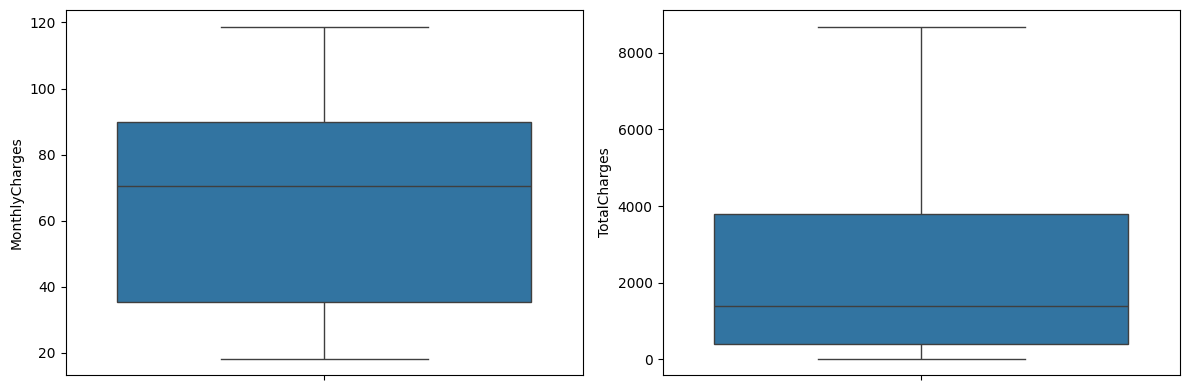

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

The variable `tenure` is related to the time that a customer remains subscribing to a certain service. In other words, it can be said to be an indication of fidelity.

Although there is no documentation, I assume that the time unit used is "month".

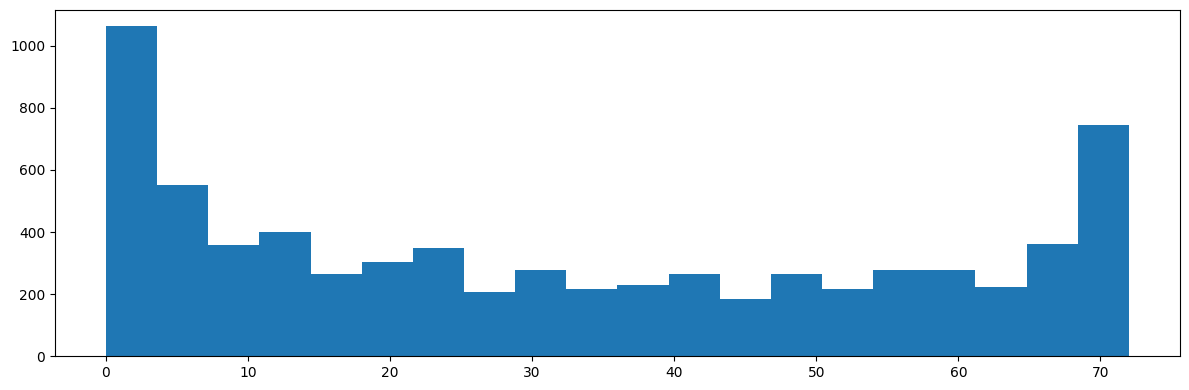

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(df['tenure'], bins=20)
plt.tight_layout()

When dealing with categorical variables, it is important to see the unique values. This allows you to identify situations such as different labels wanting to indicate the same thing.

Seeing the values ​​printed in the cell below, I understand that a data scientist might want to consider values ​​like `No`, `No phone service` and `No internet service` to be the same thing.

Although completely valid, this will not be the premise adopted here. I will consider each label individually.

In [ ]:
# check unique values ​​of categorical variables
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

To identify whether our data may have some type of bias, I will check the count of values ​​for `Male` and `Female`.

Although I do not understand that this could generate any relevant harm in this specific problem, there will be many situations where this harm will be real, as is the case with models applied to hiring employees or predicting crimes.

Below, you can see that the genre of the entries is balanced.

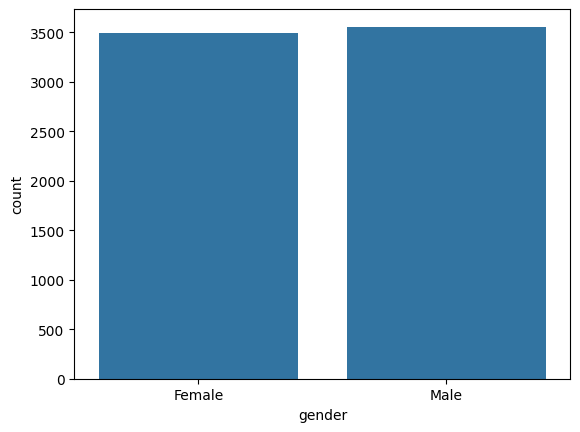

In [ ]:
sns.countplot(data=df, x='gender');

Finally, in this first exploratory analysis, we will see the balancing of the classes in the dataset.

It is possible to identify that the `No` class occurs much more frequently than the `Yes` class. This will be considered in the machine learning model construction stage.

<Axes: xlabel='Churn', ylabel='count'>

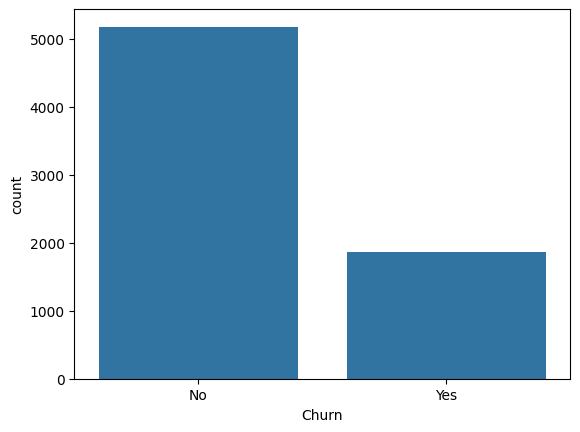

In [ ]:
sns.countplot(data=df, x='Churn')

## Prepare the Data

In this data preparation stage, basic pre-processing will be carried out, solely for the purpose of building a base model.

Features that contained 2 unique labels will be processed using `LabelEncoder`. It is worth remembering that this includes the target variable `Churn`. Next, the numerical variables will be separated from the categorical variables. The categorical variables will be transformed into dummy variables, to allow their use in all models.

In [ ]:
# preprocess the variables
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# copy dataframe
df_proc = df_clean.copy()

# Label Encoding
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# see the first 5 entries of the new dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


## Machine Learning Model

With the processing carried out in the previous step, the data can now be used in machine learning models.

To be able to compare the performance and improvement of the model, we will create a simple baseline. No adjustments will be made to the hyperparameters and no thought will be given to data balancing, feature engineering or feature selection (among others).

However, from now on it is important to separate the data that will be used as training and testing. The test data will only be used in the last stage of the project, to have a more real evaluation.

In [ ]:
# separate the feature matrix from the target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# split the data between training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y)

I will use cross-validation to estimate the error of the baseline and initial models. To facilitate and improve the code, a `val_model` function was created. The metric used for evaluation will be `recall`.

In [ ]:
def val_model(X, y, clf, quite=False):
    """
    Performs cross-validation with training data for a given model.

    # Arguments
        X: DataFrame, contains independent variables.
        y: Series, vector containing the target variable.
        clf: Scikit-learn classifier model.
        quite: bool, indicating whether the function should print the results or not.

    #Returns
        float, average of cross-validation scores.
    """

    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

    return scores.mean()

For the initial baseline, I will use Random Forest, without any type of change to the parameters. The data that will be passed is training data.

In [ ]:
# create baseline and see performance
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.47 (+/- 0.02)


Once we have a baseline to compare whether the adjustments improve or worsen the model's performance, I will balance the data and see how this will impact.

The technique chosen was Under Sampling, after some performance tests of the others. Following recommendations from some literature, the data will be standardized before using this balancing technique.

Remembering, it is important that balancing occurs only with training data. Test data must remain untouchable.

In [ ]:
# standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

I will apply cross-validation to several models in order to identify their performance and choose the best one(s). Again, only training data will be used. The chosen models are:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Logistic Regression
* LightGBM

In [ ]:
# instantiate models
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# evaluate performance (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

[LightGBM] [Info] Number of positive: 1112, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1112, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[L

,Recall
RandomForestClassifier,0.769784
DecisionTreeClassifier,0.681295
SGDClassifier,0.733813
SVC,0.790647
LogisticRegression,0.807194
XGBClassifier,0.739568
LGBMClassifier,0.772662


Given the characteristics of the problem and the performance during previous runs, I opted for XGBoost, practically tied with Logistic Regression.

My understanding is that tuning the parameters can further improve the quality of the solution. As we have few possible adjustments in Logistic Regression, I don't believe the result could pass XGBoost.

## Hyperparameter Optimization

XGBoost has numerous parameters. Some affect the quality of the model more, others less. A good practice is to define a learning rate and number of estimators, tune other parameters and, at the end, check other learning rates.

Below, I will adjust the number of estimators. The model was instantiated with `learning_rate=0.1`.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identify best parameter
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# see results
print("The best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

The best: 0.781294964028777 for {'n_estimators': 50}


With the number of estimators equal to 50, I will search for the `max_depth` and `min_child_weight` parameters.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

#identify best parameter
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# see results
print("The best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

The best: 0.8237410071942446 for {'max_depth': 1, 'min_child_weight': 1}


Once the values ​of `max_depth=1` and `min_child_weight=1` are obtained, I will optimize the `gamma` parameter.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

#identify best parameter
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# see results
print("The best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

Finally, having obtained `gamma=0`, I will test four values ​​for `learning_rate` and see which one offers the best result.

In [ ]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identify best parameter
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# see results
print("The best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

The best: 0.8812949640287769 for {'learning_rate': 0.001}


The fact is that a lower learning rate managed to improve the performance of the XGBoost model, considering `recall` as the only important metric (premise assumed by this author).

Now, the model is trained on the complete training dataset, and the final performance is verified on the test data, in its first contact with this sub-set that had been preserved.

In [ ]:
# final model
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# make the prediction
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# print the area under the curve
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))


              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1282
           1       0.44      0.90      0.59       479

    accuracy                           0.66      1761
   macro avg       0.69      0.73      0.65      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.7336



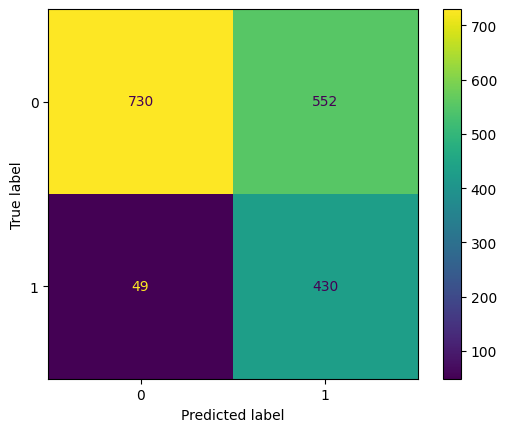

In [ ]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

## Conclusions

By applying a Machine Learning model to predict churn using XGBoost optimized with hyperparameters, we can draw several important conclusions that help understand customer behavior and the effectiveness of the model. For example:

### 1. **Importance of Variables (Feature Importance)**
   - **Identification of the most relevant variables:** XGBoost allows you to analyze the importance of the variables (features) that most contribute to churn prediction. This helps identify which factors are most associated with the risk of cancellation, such as price, service quality, frequency of use, etc.
   - **Insights for business actions:** The "customer satisfaction" factor is highly relevant, the company can focus on improving customer service to reduce churn. Especially in the first months of joining the services, using the histogram, we were able to identify this fact.

### 2. **Model Performance**
   - **Accuracy and other performance metrics:** The model is well tuned and we can see a good balance between precision and recall. According to F1-Score presented in the evaluations.
   - **Effectiveness of hyperparameters:** By optimizing XGBoost's hyperparameters, we can see how these settings impact the model's performance, improving its predictive capacity.

### 3. **Customer Segmentation**
   - **Identification of risk groups:** The model can help segment the customer base into different levels of churn risk. Customers at high risk of churn can be targeted with specific retention campaigns.
   - **Personalization of strategies:** With risk-based segmentation, retention strategies can be customized for different groups, increasing the effectiveness of actions.

### 4. **Error Analysis**
   - **Cases of false positives/negatives:** It can be seen that the model still presents some errors, but not enough to invalidate the prediction. This is a generic model, possibly consistent with everyday reality.
   - **Corrective actions:** Understanding errors allows you to implement corrective actions, such as adjustments to the data or definition of hyperparameters, to further improve the model.

### 5. **Potential Impact on Business Decisions**
   - **Strategic planning:** The model's conclusions can inform strategic decisions, such as resource allocation in retention campaigns or product/service improvements. Furthermore, the model can help reduce churn and how it can impact ROI (Return on Investment) and other important financial metrics.

### 6. **Model Validation**
   - **Model generalization:** As the model is robust and generalizes well to new data, it avoids problems such as overfitting and underfitting.